In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from AnamolayDetection import anamoly_detection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')
import heapq

AIM

this approach calculates centroids for both fraudulent and non-fraudulent data, determines the distances between these centroids, and uses these distances to find the angle between vectors. The angle is then used to estimate the likelihood of a transaction being fraudulent.

In [158]:
path='fraudTrain.csv'


                                            ### Preprocess Data ##

Create a function that accepts parameters for the number of samples and a random state, and returns a dataset categorized into two segments: fraud and non-fraud, prior to proceeding with clustering.

In [159]:
def data_point(sample,random):
    online_retail_data=pd.read_csv(path).sample(n=sample, random_state=random)
    online_retail_data.drop(['Unnamed: 0','first','last'],axis=1,inplace=True)
    online_retail_data['location_detail'] = online_retail_data.apply(lambda row: f"{row['state']}{row['city']}{row['street']}{row['zip']}{row['lat']}{row['long']}", axis=1)
    online_retail_data.drop(['street', 'city', 'state', 'zip', 'lat', 'long','merch_lat','merch_long'],axis=1,inplace=True)
    online_retail_data['dob'] = pd.to_datetime(online_retail_data['dob'])
    today = pd.to_datetime('today')
    online_retail_data['age']=pd.to_timedelta(today-online_retail_data['dob']).dt.days/365
    only_fraud=online_retail_data[['location_detail','city_pop','category','amt','age','gender','is_fraud']]
    frequency_1= only_fraud['location_detail'].value_counts()
    frequency_2= only_fraud['category'].value_counts()
    only_fraud['location_detail'] = only_fraud['location_detail'].map(frequency_1)
    only_fraud['category'] = only_fraud['category'].map(frequency_2)
    gender_map = {'M': 0, 'F': 1}
    only_fraud['gender'] = only_fraud['gender'].map(gender_map)
    only_non_fraud = only_fraud[only_fraud['is_fraud'] == 0]
    only_fraud = only_fraud[only_fraud['is_fraud'] == 1]
    return only_non_fraud ,only_fraud 

Train 

In [316]:
n=6000

In [317]:
non_fa,fa= data_point(n,20)

In [371]:
fa.shape[1]/n
rounded_result = round(fa.shape[1]/n, 4)
print(rounded_result)

0.0012


Train 

Apply MinMax scaling to normalize the data between 1 and -1. This ensures that no single feature disproportionately influences the distance-based algorithm, promoting balanced model performance.Addressing or removing all null values is also crucial.

In [319]:
def pre_process(data):
    only_fraud_f_numeric = data .select_dtypes(include=['float64', 'int64'])
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale the features in the non-fraud training set and drop any NaN values
    only_fraud_f_scaled = scaler.fit_transform(only_fraud_f_numeric)
    only_fraud_f_scaled = pd.DataFrame(only_fraud_f_scaled, columns=only_fraud_f_numeric.columns)
    only_fraud_f_scaled.dropna(inplace=True)
    only_fraud_f_scaled.reset_index(drop=True, inplace=True)
    return only_fraud_f_scaled
    


To separate out fraudulent and non-fraudulent data in a dataset, you would typically filter the data based on a column or feature that indicates whether a transaction is fraudulent or not. Assuming you have a DataFrame df with a column named fraud_flag where 1 indicates fraud and 0 indicates non-fraud, here's how you can separate the data:

In [320]:
only_fraud_scaled=pre_process(fa)
non_fraud_scaled=pre_process(non_fa)

To combine the separated fraud and non-fraud datasets back together and remove the fraud_flag column before validating the model

In [337]:
fraud_subset = only_fraud_scaled.head(5)
combined_df_tr = pd.concat([fraud_subset, non_fraud_scaled])
# Shuffle the combined DataFrame
shuffled_df_tr = combined_df_tr.sample(frac=1, random_state=42).reset_index(drop=True)
# Optionally, print the first few rows to verify
print(shuffled_df_tr.head())

   location_detail  city_pop  category       amt       age  gender  is_fraud
0         0.318182  0.007527  0.744186  0.004421  0.303606     1.0       0.0
1         0.318182  0.231646  0.595349  0.014790  0.438538     0.0       0.0
2         0.500000  0.004610  0.744186  0.021825  0.540889     0.0       0.0
3         1.000000  0.002623  0.497674  0.013680  0.204019     1.0       0.0
4         0.590909  0.003459  0.876744  0.020021  0.337962     1.0       0.0


In [338]:
clusterer = anamoly_detection.ClusterCentroid(max_iter=20, cores=4, timeout=300)


To enhance performance, we should tune the hyperparameters max_iter=20, cores=4, and timeout=300 in the clusterer = anomaly_detection.ClusterCentroid(max_iter=20, cores=4, timeout=300) configuration.

Processs

Compute Centroids: Calculate the centroid for each set of data points. This involves finding the average position of all points in each set (fraudulent and non-fraudulent).

Calculate Distances:

Distance Between Centroids: Determine the distance between the centroids of the fraudulent and non-fraudulent data sets.
Distance Within Each Centroid: Calculate the distance of each data point from its respective centroid (for both fraud and non-fraud sets).

Form Vectors:

Within-Set Vector: Construct vectors representing the distances of individual points from their own centroid.
Between-Centroid Vector: Form a vector representing the distance between the centroids of the two sets.

Calculate Angle:

Find the angle between the vectors representing the distances of individual points from their centroids and the vector representing the distance between the centroids.
This angle can be computed using the dot product formula and the arccosine function.

Estimate Fraud Probability:

Normalize the angle by dividing it by 360 degrees to estimate the probability of fraud.(depends on the hyper parameter tuning and sample size)

In [357]:

non_fra=non_fraud_scaled.copy()
non_fra['only_fraud']=1
non_fra['not_fraud']=0
fraud_test_1= non_fra.copy().drop(columns=['not_fraud'])
non_fraud_test_1= non_fra.copy().drop(columns=['only_fraud'])
centroids_data_fra_1,_ = clusterer.cluster_make(np.array(pre_process(fraud_test_1)))
centroids_data_non_fra_1,_ = clusterer.cluster_make(np.array(pre_process(non_fraud_test_1)))
try:
    a_1=anamoly_detection.compare_distance(centroids_data_fra_1,centroids_data_fra_1)
except:
    a_1=[0]
try:
    b_1=anamoly_detection.compare_distance(centroids_data_non_fra_1,centroids_data_non_fra_1)
except:
    b_1=[0]
try:
    c_1=anamoly_detection.compare_distance(centroids_data_non_fra_1,centroids_data_fra_1)
except:
    c_1=[0]
difference_angle_a=anamoly_detection.angle_between_group(b_1,c_1)-anamoly_detection.angle_between_group(a_1,c_1)

In [364]:
np.abs(difference_angle_a)

1.9950100869728828

In [365]:
non_fra=combined_df_tr.copy()
non_fra['only_fraud']=1
non_fra['not_fraud']=0
fraud_test_1= non_fra.copy().drop(columns=['not_fraud'])
non_fraud_test_1= non_fra.copy().drop(columns=['only_fraud'])
centroids_data_fra_1,_ = clusterer.cluster_make(np.array(pre_process(fraud_test_1)))
centroids_data_non_fra_1,_ = clusterer.cluster_make(np.array(pre_process(non_fraud_test_1)))
a_1=anamoly_detection.compare_distance(centroids_data_fra_1,centroids_data_fra_1)
b_1=anamoly_detection.compare_distance(centroids_data_non_fra_1,centroids_data_non_fra_1)
c_1=anamoly_detection.compare_distance(centroids_data_non_fra_1,centroids_data_fra_1)
difference_angle=anamoly_detection.angle_between_group(b_1,c_1)-anamoly_detection.angle_between_group(c_1,a_1)

In [370]:
np.abs(difference_angle)/360

0.015007597241323584

True indicates that the data contains anomalies, as a greater angle suggests the data is more heterogeneous it will true for minimum configuration.

In [369]:
True if np.abs(difference_angle) > np.abs(difference_angle_a) else False

True

In [358]:
non_fra=only_fraud_scaled.copy()
non_fra['only_fraud']=1
non_fra['not_fraud']=0
fraud_test_1= non_fra.copy().drop(columns=['not_fraud'])
non_fraud_test_1= non_fra.copy().drop(columns=['only_fraud'])
centroids_data_fra_1,_ = clusterer.cluster_make(np.array(pre_process(fraud_test_1)))
centroids_data_non_fra_1,_ = clusterer.cluster_make(np.array(pre_process(non_fraud_test_1)))
a_1=anamoly_detection.compare_distance(centroids_data_fra_1,centroids_data_fra_1)
b_1=anamoly_detection.compare_distance(centroids_data_non_fra_1,centroids_data_non_fra_1)
c_1=anamoly_detection.compare_distance(centroids_data_non_fra_1,centroids_data_fra_1)
difference_angle_f=np.abs(anamoly_detection.angle_between_group(b_1,c_1)-anamoly_detection.angle_between_group(a_1,c_1))

By comparing the angle between the vectors representing fraudulent and non-fraudulent data points, and observing that this value lies between the angles for all fraudulent and all non-fraudulent data, we can infer that the classification or anomaly detection is likely accurate.

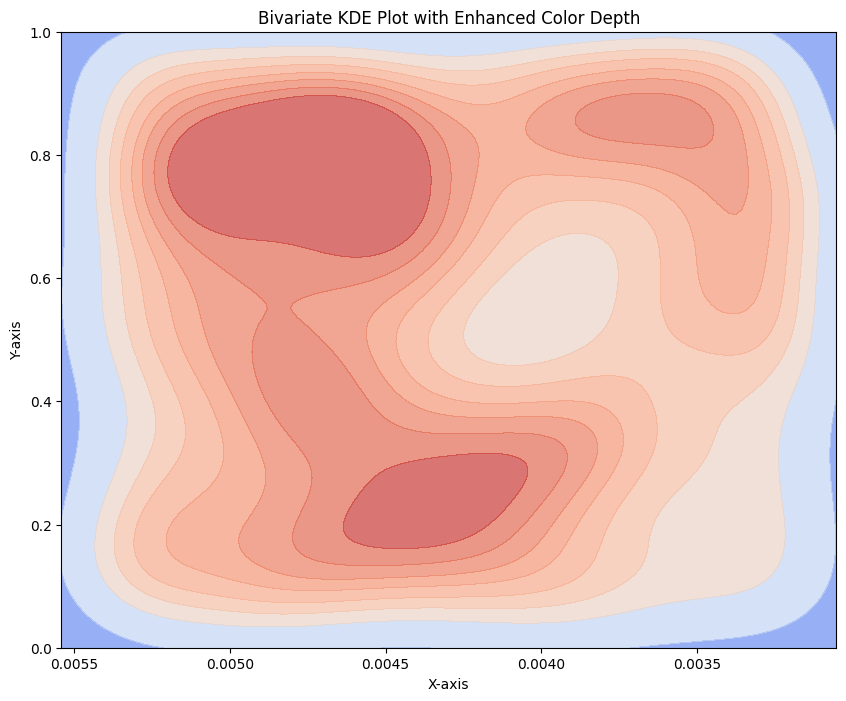

In [366]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace with your actual values
difference_angle_a = np.abs(difference_angle_a)/360 # Example value
difference_angle_f =difference_angle_f/360 # Example value

# Generate sample data
np.random.seed(0)
x = np.random.uniform(difference_angle_a, difference_angle_f, 1000)  # 1000 samples in the specified range
y = np.random.uniform(0, 1, 1000)  # 1000 samples in the range [0, 1]

# Create a DataFrame
data = pd.DataFrame({'x': x, 'y': y})

# Create a KDE plot with improved color depth
plt.figure(figsize=(10, 8))
sns.kdeplot(data=data, x='x', y='y', cmap='coolwarm', fill=True, thresh=0.05, alpha=0.7, linewidth=2)

# Set axis limits
plt.xlim(difference_angle_a, difference_angle_f)
plt.ylim(0, 1)

# Add titles and labels
plt.title('Bivariate KDE Plot with Enhanced Color Depth')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()


We can estimate that the fraud percentage lies between 0.0045 and 0.0050. This interpretation is reasonably accurate, given that the actual data shows a fraud rate of 0.0012. Further tuning of the hyperparameters could provide a more granular and precise estimate.